In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from keras.models import Model
from keras.layers import Input,Dropout,Dense,LSTM,TimeDistributed,RepeatVector
from keras import regularizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
df = pd.read_excel('CANDY CANE 101 - CLASS (1).xlsx',skiprows = 0,skipfooter = 10080)

In [3]:
df.head()

,Type of Facility,Name of Facility,Timestamp,"Wellhead Casing ""A"" - Pressure","Wellhead Casing ""B"" - Pressure",Flowline Pressure,Flowline Temperature,Volume - Calendar Day Production,Wellhead Tubing - Pressure
0,Synthetic Data,CANDY CANE WELL 101,2017-08-24 16:58:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
1,Synthetic Data,CANDY CANE WELL 101,2017-08-24 16:59:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
2,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:00:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
3,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:01:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
4,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:02:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data


In [4]:
# Convert remaining parameters to float and fill missing values with the mean
df['Wellhead Casing \"A\" - Pressure'] = pd.to_numeric(df['Wellhead Casing \"A\" - Pressure'], errors='coerce').astype(float)
df['Wellhead Casing \"B\" - Pressure'] = pd.to_numeric(df['Wellhead Casing \"B\" - Pressure'], errors='coerce').astype(float)
df['Flowline Pressure'] = pd.to_numeric(df['Flowline Pressure'], errors='coerce').astype(float)
df['Flowline Temperature'] = pd.to_numeric(df['Flowline Temperature'], errors='coerce').astype(float)
df['Volume - Calendar Day Production'] = pd.to_numeric(df['Volume - Calendar Day Production'], errors='coerce').astype(float)
df['Wellhead Tubing - Pressure'] = pd.to_numeric(df['Wellhead Tubing - Pressure'], errors='coerce').astype(float)
# Fill data for Wellhead Casing \"B\" - Pressure when missing 
df['Wellhead Casing \"B\" - Pressure'] = df['Wellhead Casing \"B\" - Pressure'].fillna(df['Wellhead Tubing - Pressure'].rolling(window = 2880).mean())

In [5]:
# Replace the missing values with the mean
df['Wellhead Casing \"A\" - Pressure'] = df['Wellhead Casing \"A\" - Pressure'].fillna(df['Wellhead Casing \"A\" - Pressure'].mean())
df['Wellhead Casing \"B\" - Pressure'] = df['Wellhead Casing \"B\" - Pressure'].fillna(df['Wellhead Casing \"B\" - Pressure'].mean())
df['Flowline Pressure'] = df['Flowline Pressure'].fillna(df['Flowline Pressure'].mean())
df['Flowline Temperature'] = df['Flowline Temperature'].fillna(df['Flowline Temperature'].mean())
df['Volume - Calendar Day Production'] = df['Volume - Calendar Day Production'].fillna(df['Volume - Calendar Day Production'].mean())
df['Wellhead Tubing - Pressure'] = df['Wellhead Tubing - Pressure'].fillna(df['Wellhead Tubing - Pressure'].mean())

In [6]:
#Now all data are either in the correct type, or NaN
df.describe(include='all')

,Type of Facility,Name of Facility,Timestamp,"Wellhead Casing ""A"" - Pressure","Wellhead Casing ""B"" - Pressure",Flowline Pressure,Flowline Temperature,Volume - Calendar Day Production,Wellhead Tubing - Pressure
count,412298,412298,412298,412298.000000,412298.000000,412298.000000,412298.000000,412298.000000,412298.000000
unique,1,1,412298,NaN,NaN,NaN,NaN,NaN,NaN
top,Synthetic Data,CANDY CANE WELL 101,2018-04-07 10:18:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,412298,412298,1,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2017-08-24 16:58:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-06-07 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1706.335201,981.323623,543.289889,51.962584,6860.164167,976.015068
std,NaN,NaN,NaN,766.892720,490.583967,217.699613,22.312568,3031.188649,522.458343
min,NaN,NaN,NaN,-0.914997,-3.313369,-0.436380,0.000000,0.000000,-4.117486
25%,NaN,NaN,NaN,1579.284424,817.146290,535.271790,45.519485,6771.974121,811.828888


In [7]:
#we will now fix values that are negative as they are indicated as wrong value
#all negative will be relaced by the value before it
def replace_error_value(col):
    for i in range(len(col)):
        if(col[i] < 0):
            col[i] = col[i - 1]
    return col

In [8]:
df["Wellhead Casing \"A\" - Pressure"] = replace_error_value(df["Wellhead Casing \"A\" - Pressure"])
df["Flowline Pressure"] = replace_error_value(df["Flowline Pressure"])
df["Wellhead Tubing - Pressure"] = replace_error_value(df["Wellhead Tubing - Pressure"])
#caculate rolling mean for "Wellhead Casing "B" - Pressure" from "Wellhead Casing "A" - Pressure"
df["Wellhead Casing \"B\" - Pressure"] = df["Wellhead Casing \"A\" - Pressure"].rolling(3600).mean().fillna(0)

C:\Users\yingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
#Now all the data look okay, with no negative value
# we will being our exploration
df.describe()

,"Wellhead Casing ""A"" - Pressure","Wellhead Casing ""B"" - Pressure",Flowline Pressure,Flowline Temperature,Volume - Calendar Day Production,Wellhead Tubing - Pressure
count,412298.000000,412298.000000,412298.000000,412298.000000,412298.000000,412298.000000
mean,1706.335420,1699.394078,543.344784,51.962584,6860.164167,976.052210
std,766.892233,759.681566,217.610246,22.312568,3031.188649,522.388850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1579.284424,1590.524909,535.271790,45.519485,6771.974121,811.828888
50%,1791.334961,1787.976409,628.047974,53.281227,7690.985352,947.479187
75%,2179.522461,2112.170964,664.632874,61.761673,8858.786133,1254.689331
max,5138.380371,3238.101429,1375.019043,132.943359,11657.337891,3257.159912


#LSTM

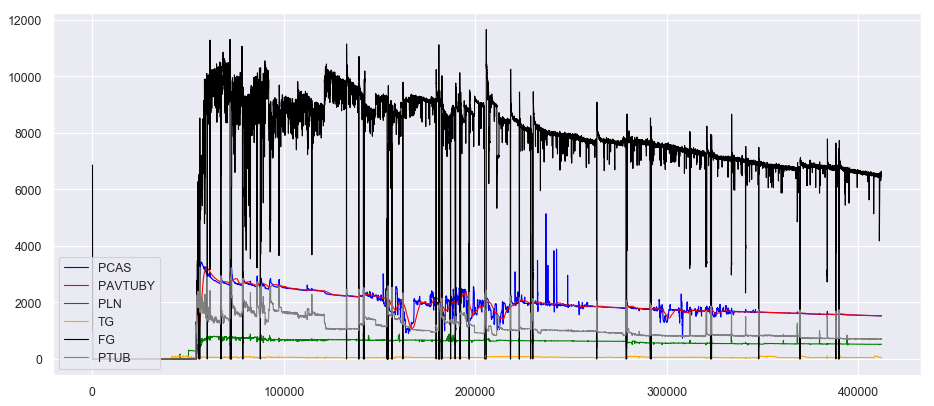

In [10]:
#Plotting
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['Wellhead Casing "A" - Pressure'], label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(df['Wellhead Casing "B" - Pressure'], label='PAVTUBY', color='red', animated=True, linewidth=1)
ax.plot(df['Flowline Pressure'], label='PLN', color='green', animated=True, linewidth=1)
ax.plot(df['Flowline Temperature'], label='TG', color='orange', animated=True, linewidth=1)
ax.plot(df['Volume - Calendar Day Production'], label='FG', color='black', animated=True, linewidth=1)
ax.plot(df['Wellhead Tubing - Pressure'], label='PTUB', color='grey', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

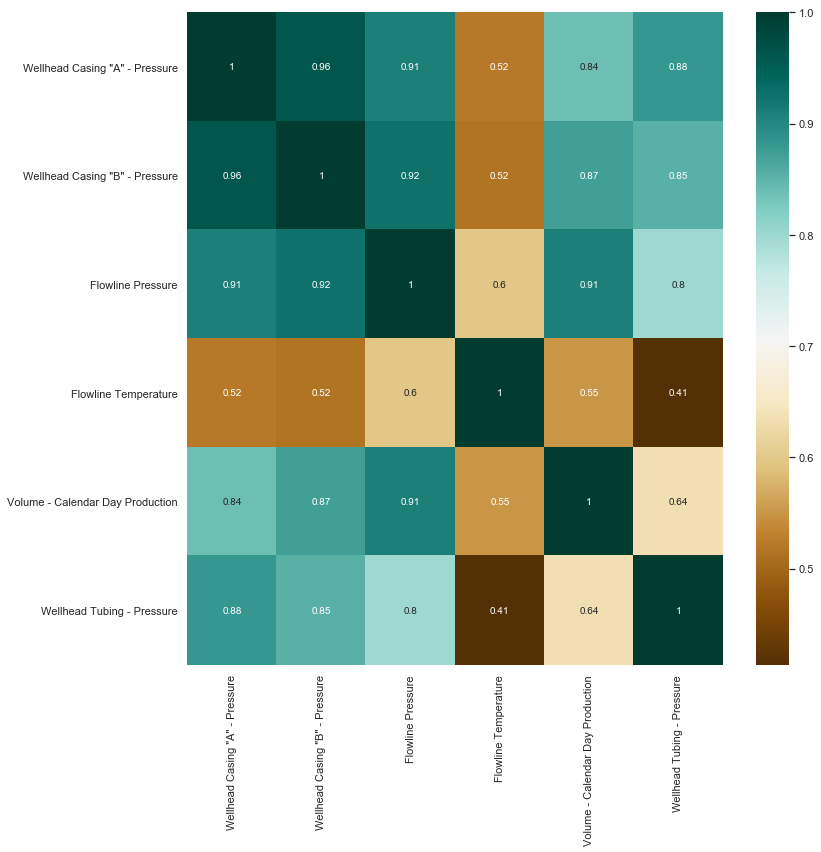

In [11]:
#Correlation
corr = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='BrBG', annot=True)

# Wellhead Casing "A" - Pressure , Wellhead Tubing - Pressure

In [12]:
#Concatenate two type of pressure
merged_data = pd.DataFrame()
merged_data = pd.concat([merged_data, df['Wellhead Casing "A" - Pressure']], axis = 1)
merged_data = pd.concat([merged_data, df['Wellhead Tubing - Pressure']], axis = 1)
merged_data.index = pd.to_datetime(df['Timestamp'])
merged_data = merged_data.sort_index()
merged_data.head()

,"Wellhead Casing ""A"" - Pressure",Wellhead Tubing - Pressure
Timestamp,,
2017-08-24 16:58:00,1706.335201,976.015068
2017-08-24 16:59:00,1706.335201,976.015068
2017-08-24 17:00:00,1706.335201,976.015068
2017-08-24 17:01:00,1706.335201,976.015068
2017-08-24 17:02:00,1706.335201,976.015068


In [13]:
train = merged_data.iloc[0:280000]
test = merged_data.iloc[280000:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (280000, 2)
Test dataset shape: (132298, 2)


C:\Users\yingy\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


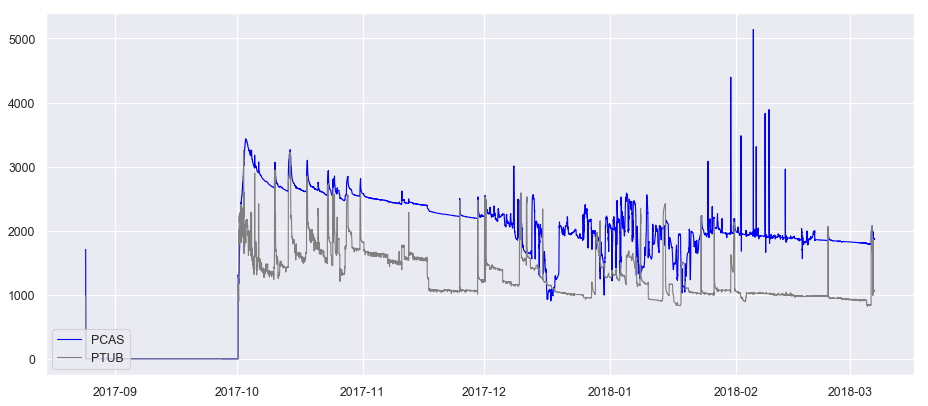

In [14]:
#Plot the training set sensor readings which represent normal operating conditions for the bearings.
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Wellhead Casing "A" - Pressure'], label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(train['Wellhead Tubing - Pressure'], label='PTUB', color='grey', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

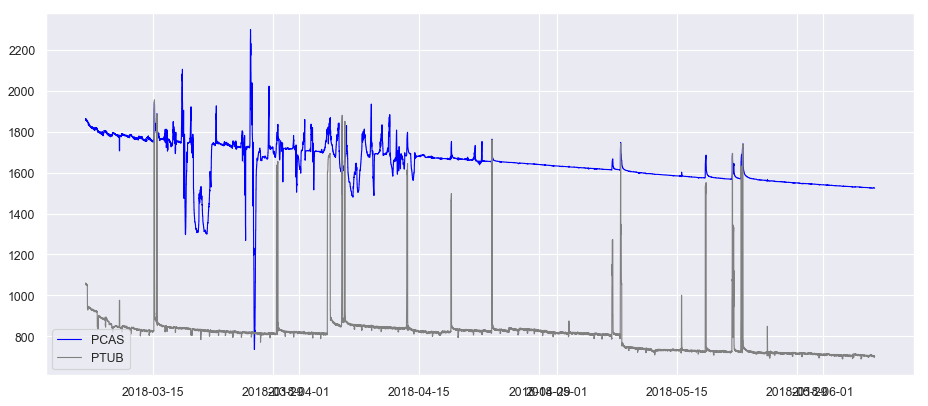

In [15]:
#Plot the test dataset sensor readings over time. 
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Wellhead Casing "A" - Pressure'], label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(test['Wellhead Tubing - Pressure'], label='PTUB', color='grey', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

In [16]:
#Transforming data from the time domain to the frequency domain using fast Fourier transfrom.
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

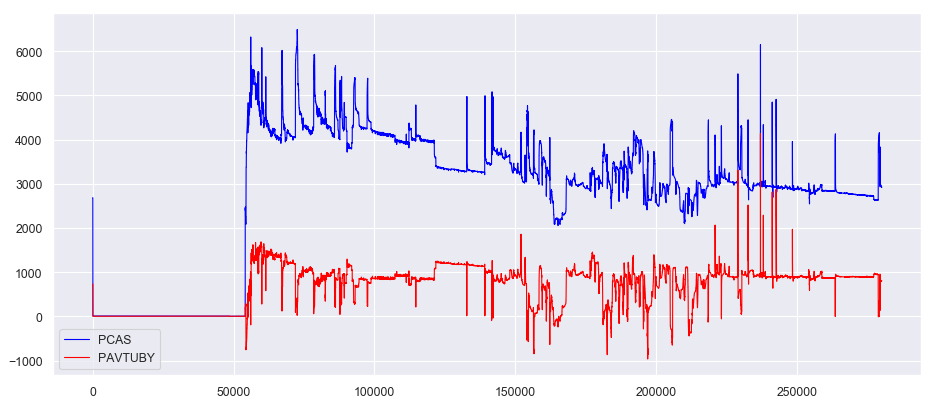

In [17]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(train_fft[:,1].real, label='PAVTUBY', color='red', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

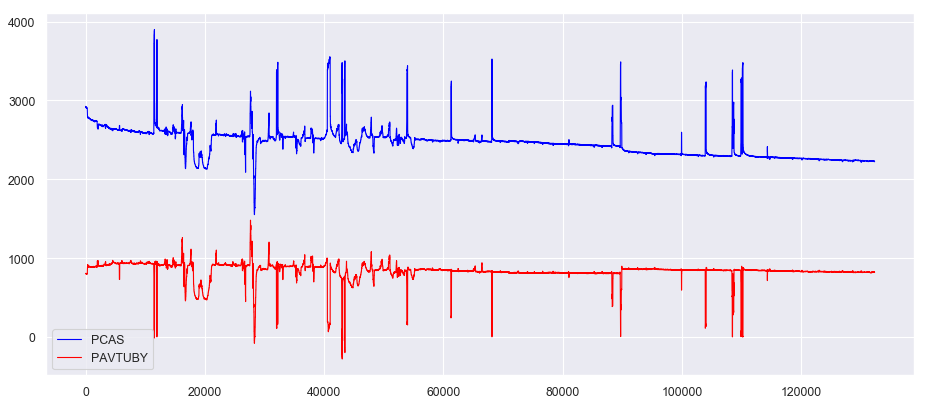

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(test_fft[:,1].real, label='PAVTUBY', color='red', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

To complete the pre-processing of our data, we will first normalize it to a range between 0 and 1. Then we reshape our data into a format suitable for input into an LSTM network.

In [19]:
#Normalize the data to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.fit_transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [20]:
#reshape inputs for LSTM
X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
print("Training dataset shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1 , X_test.shape[1])
print("Test dataset shape:", X_test.shape)

Training dataset shape: (280000, 1, 2)
Test dataset shape: (132298, 1, 2)


In [21]:
#deinfe the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In the LSTM autoencoder network architecture, the first couple of neural network layers create the compressed representation of the input data, the encoder. We then use a repeat vector layer to distribute the compressed representational vector across the time steps of the decoder. The final output layer of the decoder provides us the reconstructed input data.
We then instantiate the model and compile it using Adam as our neural network optimizer and mean absolute error for calculating our loss function.

In [22]:
#create the autoencode model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1216      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 2)              34  

Finally, we fit the model to our training data and train it for 100 epochs. We then plot the training losses to evaluate our model’s performance.

In [23]:
#fit the model to the data
nb_epochs = 30
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                   validation_split=0.05).history

Train on 266000 samples, validate on 14000 samples
Epoch 1/30
266000/266000 [==============================] - 132s 496us/step - loss: 0.0182 - val_loss: 0.0022
Epoch 2/30
266000/266000 [==============================] - 120s 452us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 3/30
266000/266000 [==============================] - 122s 457us/step - loss: 0.0011 - val_loss: 6.1138e-04
Epoch 4/30
266000/266000 [==============================] - 117s 439us/step - loss: 0.0010 - val_loss: 5.7627e-04
Epoch 5/30
266000/266000 [==============================] - 96s 363us/step - loss: 9.7857e-04 - val_loss: 0.0014
Epoch 6/30
266000/266000 [==============================] - 85s 318us/step - loss: 9.7356e-04 - val_loss: 0.0018
Epoch 7/30
266000/266000 [==============================] - 81s 306us/step - loss: 9.6330e-04 - val_loss: 6.4687e-04
Epoch 8/30
266000/266000 [==============================] - 80s 301us/step - loss: 9.5323e-04 - val_loss: 2.9955e-04
Epoch 9/30
266000/266000 [===============

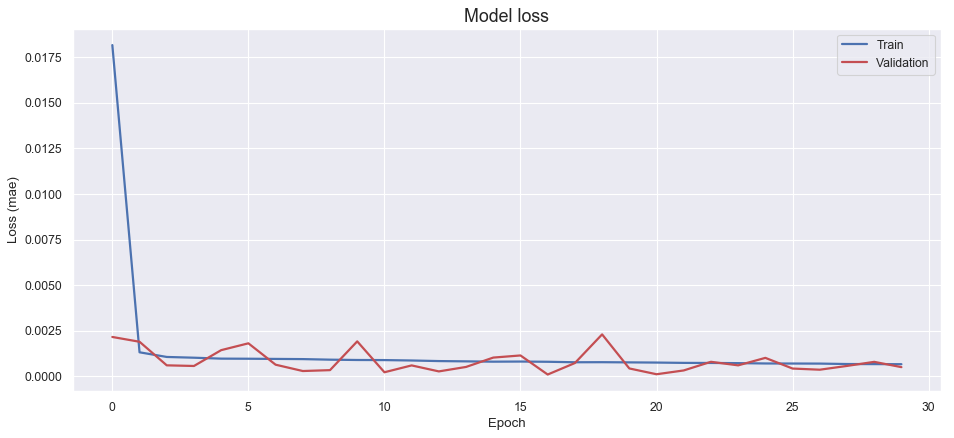

In [24]:
#plot the training losses
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Loss Distribution

(0.0, 0.5)

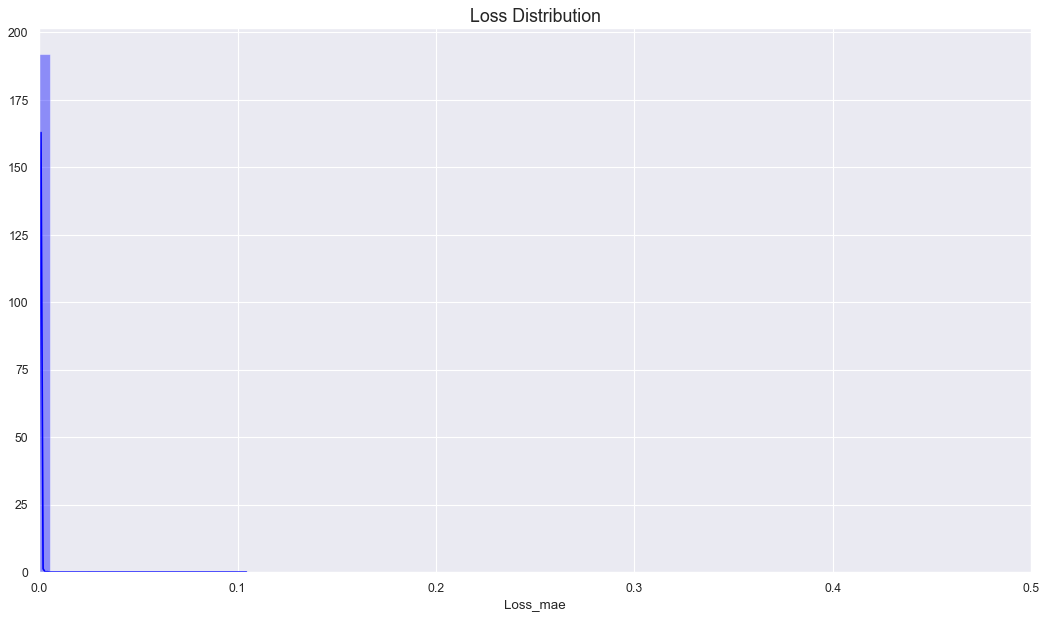

In [25]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');
plt.xlim([0.0, .5])

(0.0, 0.15)

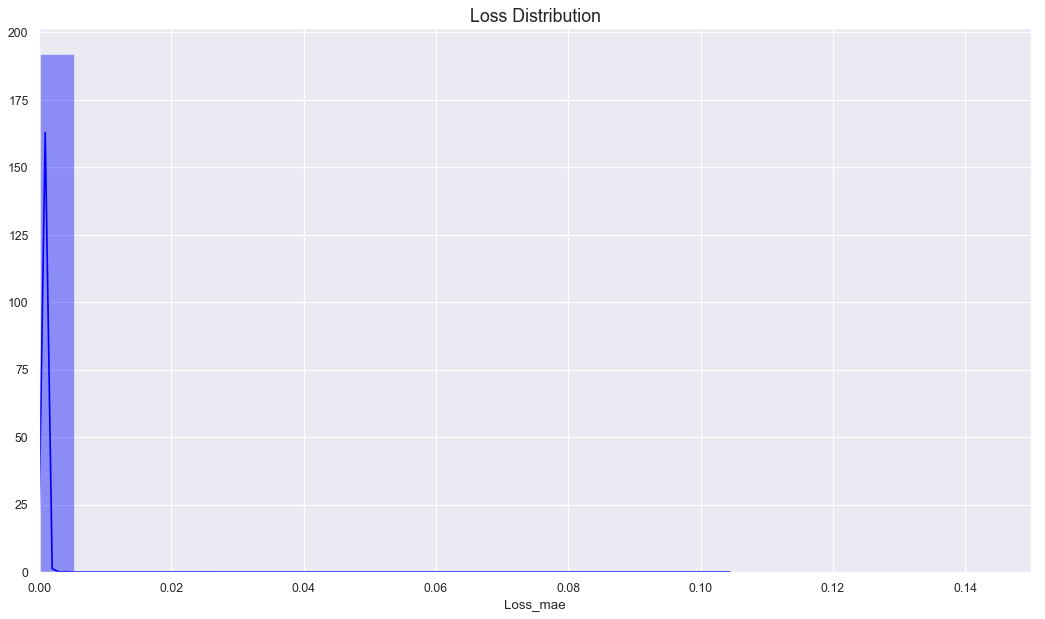

In [26]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');
plt.xlim([0.0, 0.15])

In [27]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.1
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2018-03-07 03:38:00,0.015934,0.1,False
2018-03-07 03:39:00,0.015934,0.1,False
2018-03-07 03:40:00,0.015934,0.1,False
2018-03-07 03:41:00,0.015934,0.1,False
2018-03-07 03:42:00,0.015934,0.1,False


In [28]:
#for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.head()

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2017-08-24 16:58:00,0.000586,0.1,False
2017-08-24 16:59:00,0.000586,0.1,False
2017-08-24 17:00:00,0.000586,0.1,False
2017-08-24 17:01:00,0.000586,0.1,False
2017-08-24 17:02:00,0.000586,0.1,False


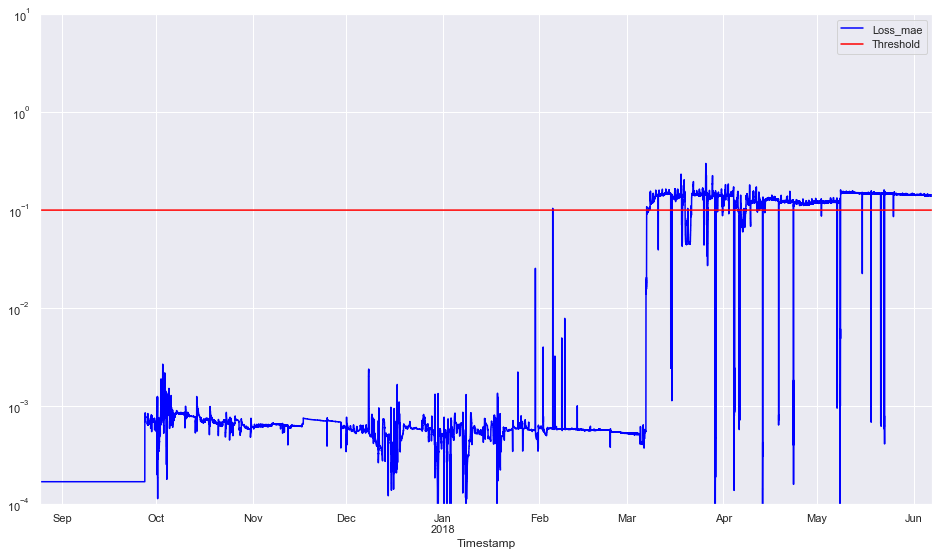

In [29]:
scored.plot(logy=True, figsize=(16,9), ylim=[1e-4,1e1], color=['blue','red'])

#  Wellhead Casing "A" - Pressure , Volume - Calendar Day Production

In [30]:
# merge pressure
merged_data = pd.DataFrame()
merged_data = pd.concat([merged_data, df['Wellhead Casing "A" - Pressure']], axis = 1)
merged_data = pd.concat([merged_data, df['Volume - Calendar Day Production']], axis = 1)
merged_data.index = pd.to_datetime(df['Timestamp'])
merged_data = merged_data.sort_index()
merged_data.head()

,"Wellhead Casing ""A"" - Pressure",Volume - Calendar Day Production
Timestamp,,
2017-08-24 16:58:00,1706.335201,6860.164167
2017-08-24 16:59:00,1706.335201,6860.164167
2017-08-24 17:00:00,1706.335201,6860.164167
2017-08-24 17:01:00,1706.335201,6860.164167
2017-08-24 17:02:00,1706.335201,6860.164167


In [31]:
train = merged_data.iloc[0:280000]
test = merged_data.iloc[280000:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (280000, 2)
Test dataset shape: (132298, 2)


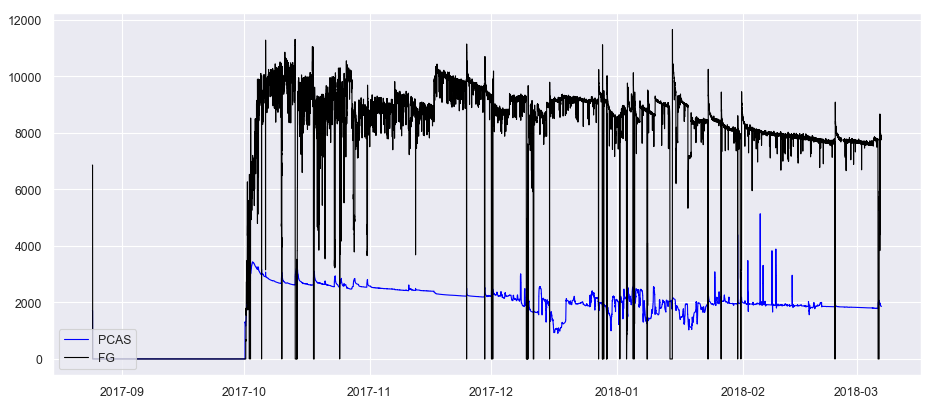

In [32]:
#Plot the training set sensor readings which represent normal operating conditions for the bearings.
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Wellhead Casing "A" - Pressure'], label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(train['Volume - Calendar Day Production'], label='FG', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

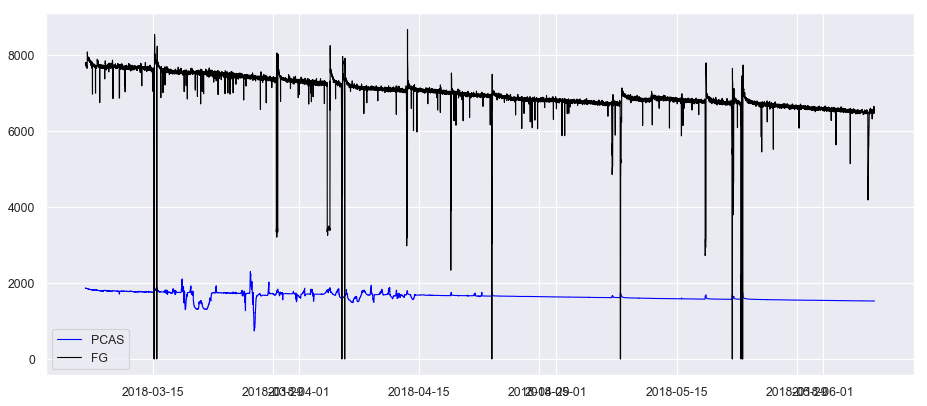

In [33]:
#Plot the test dataset sensor readings over time. 
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Wellhead Casing "A" - Pressure'], label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(test['Volume - Calendar Day Production'], label='FG', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

In [34]:
#Transforming data from the time domain to the frequency domain using fast Fourier transfrom.
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

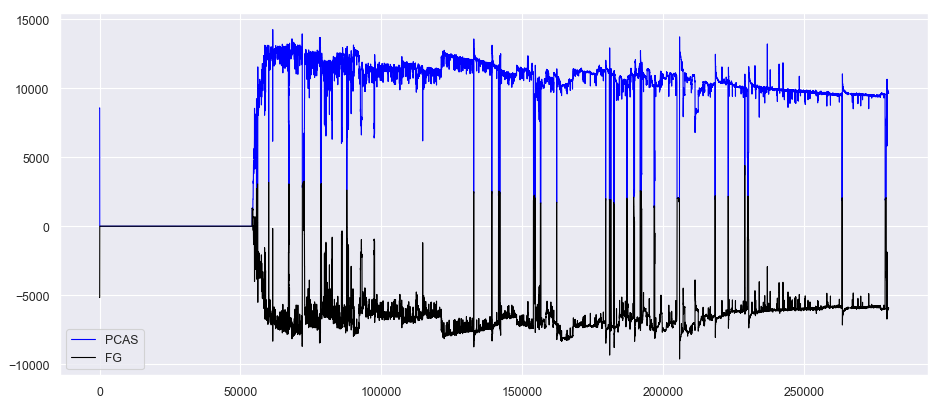

In [35]:
# Let’s first look at the training data in the frequency domain
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(train_fft[:,1].real, label='FG', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

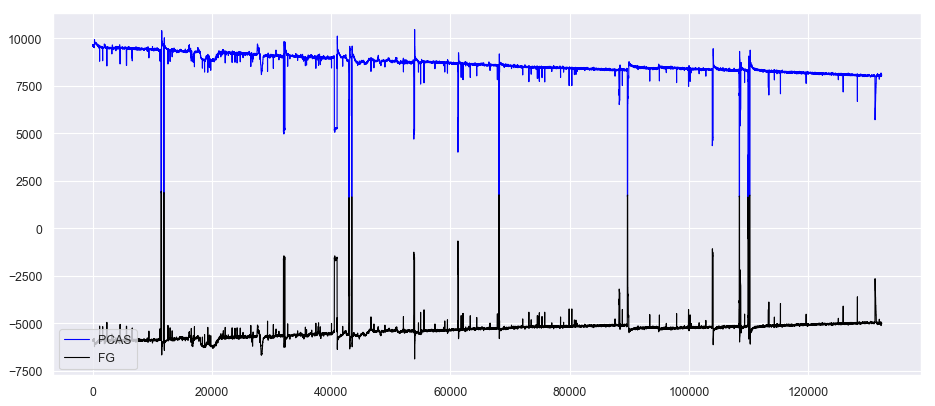

In [36]:
# test data in the frequency domain
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='PCAS', color='blue', animated=True, linewidth=1)
ax.plot(test_fft[:,1].real, label='FG', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
plt.show()

In [37]:
#Normalize the data to a range between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.fit_transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [38]:
#reshape inputs for LSTM
X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
print("Training dataset shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1 , X_test.shape[1])
print("Test dataset shape:", X_test.shape)

Training dataset shape: (280000, 1, 2)
Test dataset shape: (132298, 1, 2)


In [39]:
#deinfe the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [40]:
#create the autoencode model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 16)             1216      
_________________________________________________________________
lstm_6 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 2)              34  

In [41]:
#fit the model to the data
nb_epochs = 50
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                   validation_split=0.05).history

Train on 266000 samples, validate on 14000 samples
Epoch 1/50
266000/266000 [==============================] - 89s 334us/step - loss: 0.0203 - val_loss: 0.0051
Epoch 2/50
266000/266000 [==============================] - 82s 309us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 3/50
266000/266000 [==============================] - 80s 300us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/50
266000/266000 [==============================] - 79s 298us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/50
266000/266000 [==============================] - 79s 295us/step - loss: 0.0016 - val_loss: 3.8937e-04
Epoch 6/50
266000/266000 [==============================] - 78s 295us/step - loss: 0.0015 - val_loss: 8.7820e-04
Epoch 7/50
266000/266000 [==============================] - 78s 294us/step - loss: 0.0015 - val_loss: 5.3973e-04
Epoch 8/50
266000/266000 [==============================] - 79s 297us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 9/50
266000/266000 [==============================] - 79s 2

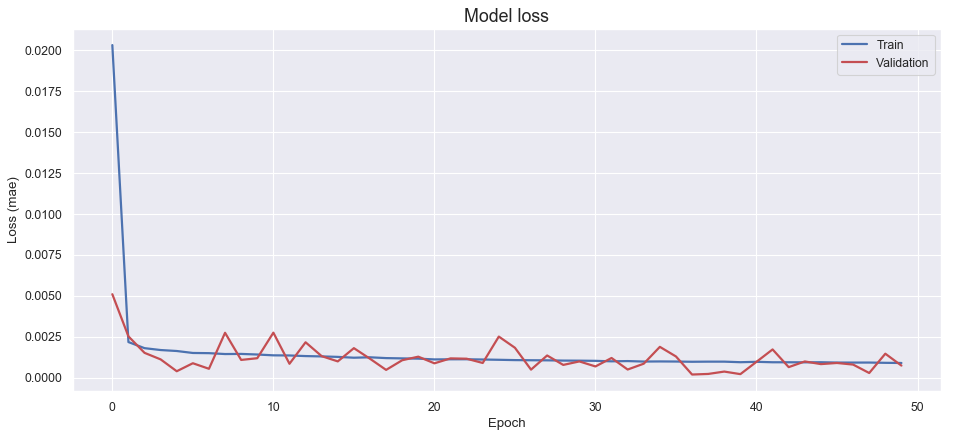

In [42]:
#plot the training losses
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Loss Distribution

By plotting the distribution of the calculated loss in the training set, we can determine a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” so that false positives are not triggered.

(0.0, 0.5)

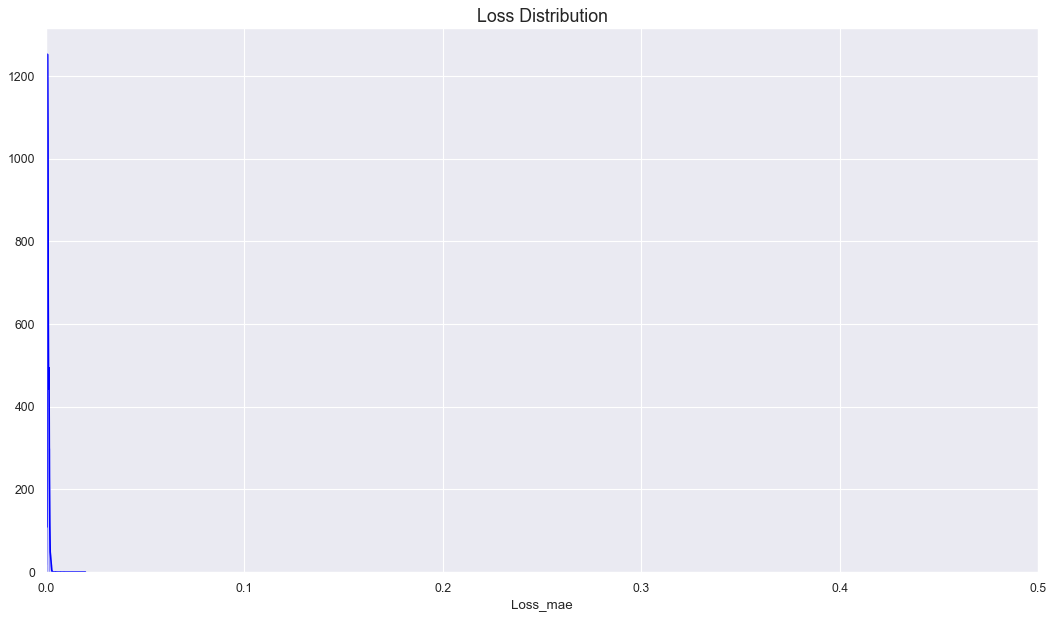

In [43]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');
plt.xlim([0.0, .5])

Based on the above loss distribution, let’s try a threshold value of 0.2 for flagging an anomaly. We then calculate the reconstruction loss in the training and test sets to determine when the sensor readings cross the anomaly threshold.

In [44]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.1
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2018-03-07 03:38:00,0.008306,0.1,False
2018-03-07 03:39:00,0.008306,0.1,False
2018-03-07 03:40:00,0.008306,0.1,False
2018-03-07 03:41:00,0.008306,0.1,False
2018-03-07 03:42:00,0.008306,0.1,False


In [45]:
#for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.head()

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2017-08-24 16:58:00,0.000841,0.1,False
2017-08-24 16:59:00,0.000841,0.1,False
2017-08-24 17:00:00,0.000841,0.1,False
2017-08-24 17:01:00,0.000841,0.1,False
2017-08-24 17:02:00,0.000841,0.1,False


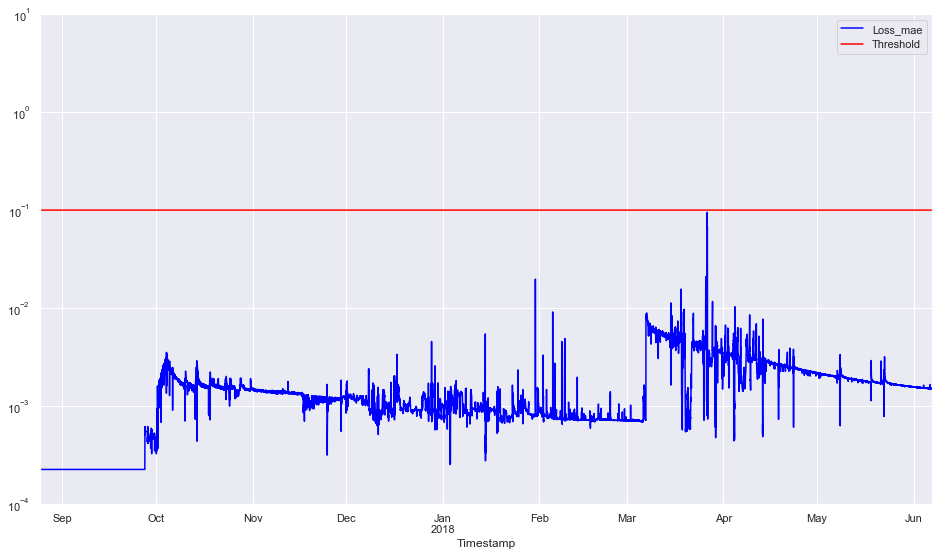

In [46]:
scored.plot(logy=True, figsize=(16,9), ylim=[1e-4,1e1], color=['blue','red'])